# Project Notebook IV: Supervised Learning with SVM with Hyperparameter Tuning as Benchmark

David Chen

In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
import boto3

In [2]:
## My custom helper functions
from helpers import *

## Step 1. Sagemaker Resources & Processed+FeatureSelected Data Saved in S3

In [3]:
sagemaker_session = sagemaker.Session()
sagemaker_session

In [4]:
role = sagemaker.get_execution_role()
role

'arn:aws:iam::644307290749:role/service-role/AmazonSageMaker-ExecutionRole-20210527T073969'

In [5]:
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-us-west-1-644307290749'

In [6]:
## Load processed, L1-selected features:
genes = pd.read_csv(get_s3_uri("assets/processed_data/genes_l1_selected.csv", bucket), index_col=0)
genes.shape

(999, 33)

In [7]:
## Load processed patient annotations (with defined class label):
clinical = pd.read_csv(get_s3_uri("assets/processed_data/clinical.csv", bucket))
clinical.index = clinical['Sample ID'].values
clinical.shape

(999, 15)

In [8]:
## Check to see if patient IDs in the 2 DataFrames match
assert all(genes.index == clinical.index)

## Step 2. Train-val-test split for Hyperparameter Tuning

Here, I will split the data into the following sets:

* Training Set (for Hyperparameter Tuning)
* Validation Set (Hyperparameter Tuning)
* Test Set (no labels, just features)

The approach will match that of the main model XGBoost as closely as possible, including:

* Maximum 20 candidates for Random Search
* Identical 100 test set examples

In [9]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(
    genes, 
    clinical["Label"].astype(int), 
    test_size = 100, 
    random_state = 42 #reproducibility
)

## Step 3. Train SVM with Hyperparameter Tuning

Use the same strategy here as in XGBoost

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from scipy import stats

NUM_CANDIDATES = 20
SVM_PARAMS = {'C': stats.expon(scale=100), 'gamma': stats.expon(scale=0.1)}

In [11]:
random_search = RandomizedSearchCV(
    SVC(probability=True, kernel="rbf"), 
    param_distributions = SVM_PARAMS, 
    n_iter = NUM_CANDIDATES,
    scoring = "roc_auc"
)

random_search.fit(Xtrain, ytrain)

RandomizedSearchCV(estimator=SVC(probability=True), n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe6a5df9550>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe6a5df9710>},
                   scoring='roc_auc')

In [12]:
df_tune = pd.DataFrame({
    "Hyperparam C": random_search.cv_results_["param_C"],
    "Hyperparam gamma": random_search.cv_results_["param_gamma"],
    "mean_AUC_score": random_search.cv_results_['mean_test_score']
})

df_tune.sort_values(by="mean_AUC_score", ascending=False, inplace=True)
df_tune

,Hyperparam C,Hyperparam gamma,mean_AUC_score
12,442.138,0.0361924,0.960629
0,32.2037,0.0483688,0.960476
9,27.9179,0.0531682,0.960237
7,110.013,0.0328842,0.960069
5,421.374,0.0443586,0.960039
14,72.6956,0.0739451,0.958958
4,86.2225,0.0768489,0.958667
8,463.824,0.0220753,0.958461
2,287.732,0.0854741,0.958356
1,120.233,0.0184938,0.956972


In [13]:
random_search.best_score_ #double-check

0.96062893081761

### Show evaluation metrics on the hold-out Test Set

In [14]:
## Retrieve the best model:
svm = random_search.best_estimator_

In [15]:
yTestScore = svm.predict_proba(Xtest)

In [16]:
yTestPred = svm.predict(Xtest)

In [17]:
print(metrics.classification_report(ytest, yTestPred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        89
           1       0.73      0.73      0.73        11

    accuracy                           0.94       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.94      0.94      0.94       100



In [18]:
## Confusion matrix
metrics.confusion_matrix(ytest, yTestPred)

array([[86,  3],
       [ 3,  8]])

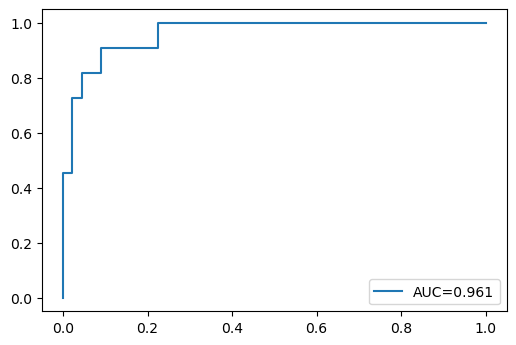

In [19]:
plot_roc(ytest, yTestScore[:,1])